# Image Segmentation

The algorithm consists of four steps:

### (i) re-segment the image,

### (ii) sample noise model parameters,

### (iii) sample MRF model parameters,

### (iv) sample the number of classes.

We will implement each of those sections below.

If you need to access the paper, go here:
https://static.aminer.org/pdf/PDF/000/180/822/unsupervised_image_segmentation_using_markov_random_field_models.pdf

In [8]:
import numpy as np

## Run the entire algorithm on an image.

In [9]:
def segment(img, numiter=100, alpha=(1.1, 10.0)):
    """Runs the entire segmentation algorithm.
    
    Inputs:
    
      img (ndarray) : a grayscale image to be segmented.
      
      numiter (int) : the number of iterations to compute.
      
      alpha (tuple (int)) : two constants used to calculate 
              geometric annealing temperature.
              
    Outputs:
      
      segmentation (ndarray) : an array of the same shape as 
            img where each entry is an integer indicating the
            class to which that pixel should belong.
    """
    
    # Initialize parameters.
    params = (None, None, None)
    
    # Segment the image.
    for t in range(numiter):
        # Obtain the temperature.
        T_t = (1 + alpha[0])**(alpha[1]*(1 - t/numiter))
        
        # Re-segment.
        segmentation = re_segment(img, t, alpha, params)

        # Sample noise parameters.
        noise_params = sample_noise() # returns a dict

        # Sample MRF parameters.
        MRF_params = sample_MRF() # returns a dict

        # Sample # of classes.
        num_classes = sample_num_classes() # returns an int
        
        # The parameters consist of noise model params, 
        #  MRF model params, and the number of classes.
        params = (noise_parames, MRF_params, num_classes)
    
    return segmentation
    

In [10]:
def re_segment(img, t, alpha, params):
    """
    Returns the segmentation array by computing the probability
    of each pixel being in each class and returning the argmax
    """
    noise_params, MRF_params, num_classes = params
    
    # Obtain the temperature.
    T_t = (1 + alpha[0])**(alpha[1]*(1 - t/numiter))
    
    probs = np.zeros((num_classes, img.shape[0], img.shape[1]))
    
    for c in range(num_classes):
        # Get the parameters for this class.
        mu = noise_params['mu'][c]
        sig = noise_params['sig'][c]
        beta0 = MRF_params['beta0'][c]
        beta1 = MRF_params['beta1'][c]
        
        # Compute the probabilities for this class
        probs[idx] = 1/np.sqrt(2*np.pi*T_t*sig**2)*np.exp(
            -1/T_t*(0.5*((img - mu)/sig)**2 
             + (beta0 + beta1*V(c, eta))) # FIXME: what's eta?
        ) # FIXME: define the function V()
    
    
    return np.argmax(probs, axis=0)

In [11]:
def sample_noise():
    """Samples the noise model parameters.
    The output is a dictionary with these keys:
    {
     'mu': an array with the mean for each class
     'sig': an array with the st. dev. for each class
    }"""
    pass

In [12]:
def sample_MRF():
    """Samples the MRF model parameters.
    The output is a dictionary with these keys:
    {
     'beta0': an array with beta0 for each class 
     'beta1': an array with beta1 for each class
    }
    """
    pass

In [13]:
def sample_num_classes():
    """Return an integer with the number of classes."""
    pass

In [15]:
import matplotlib.pyplot as plt

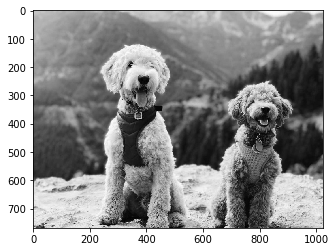

In [18]:
Y = plt.imread('dogs.jpg') / 255
Y = np.mean(Y, axis = 2)
plt.imshow(Y, cmap = 'gray')
plt.show()

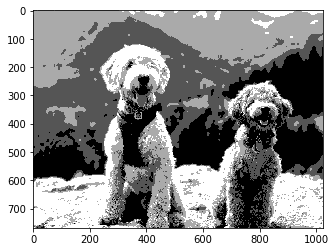

In [19]:
X = Y // (64/255)
plt.imshow(X, cmap = 'gray')
plt.show()

In [41]:
def acceptance_ratio(img_c, old_params, new_params, num_classes):
    mu_old, sig_old, T_old = old_params
    
    mu_new, sig_new, T_new = new_params
    
    ratios = []
    for s in img_c:
        new_likelihood = 1/(sig_new**2*T_new) * np.exp(-1/(2*T_new) * ((s - mu_new)/sig_new)**2)
        old_likelihood = 1/(sig_old**2*T_old) * np.exp(-1/(2*T_old) * ((s - mu_old)/sig_old)**2)
        ratios.append(new_likelihood/old_likelihood)
    print(ratios)
    acc_ratio = np.prod(np.array(ratios))
    return acc_ratio




In [42]:
img_c = Y.reshape(-1)[np.where(X.reshape(-1) == 0)]
img_c = np.random.uniform(0, 1, 10)
acceptance_ratio(img_c, (.3, .015, 1600), (.3, .01, 1600), 1)

[2.2397752092033705, 1.2684146186992658, 1.3392059558215588, 1.038052998938178, 1.8053228348709551, 1.777324593444941, 1.9401100621655938, 1.7651251508235952, 1.9408840109764904, 1.2293866904535173]


103.54858249166524

In [44]:

X = np.random.normal(0,1,(100,100))

AttributeError: 'numpy.ndarray' object has no attribute 'get_array'

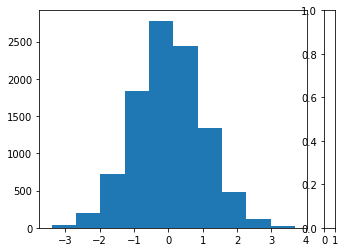

In [53]:
plt.hist(X.flatten())
plt.colorbar(X.flatten())
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'get_array'

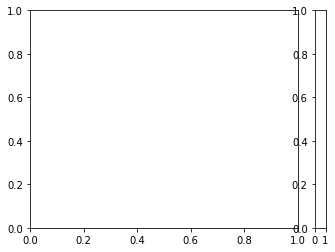